<a href="https://colab.research.google.com/github/abrazzaq02/ANN-DL/blob/main/NLP_LabSession5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural NLP using LSTM

This lab introduces **LSTM (Long Short-Term Memory)** networks for sentiment analysis using the **IMDb movie review dataset**. We'll learn to preprocess data, train an LSTM model, and evaluate its performance.

#**What is LSTM?**
Long Short-Term Memory (LSTM) is an enhanced version of the Recurrent Neural Network (RNN) designed by Hochreiter and Schmidhuber. LSTMs can capture long-term dependencies in sequential data making them ideal for tasks like language translation, speech recognition and time series forecasting. Unlike traditional RNNs which use a single hidden state passed through time LSTMs introduce a memory cell that holds information over extended periods addressing the challenge of learning long-term dependencies.
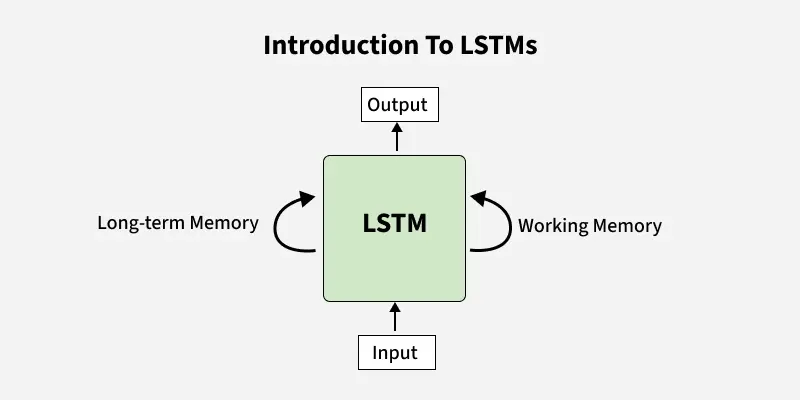
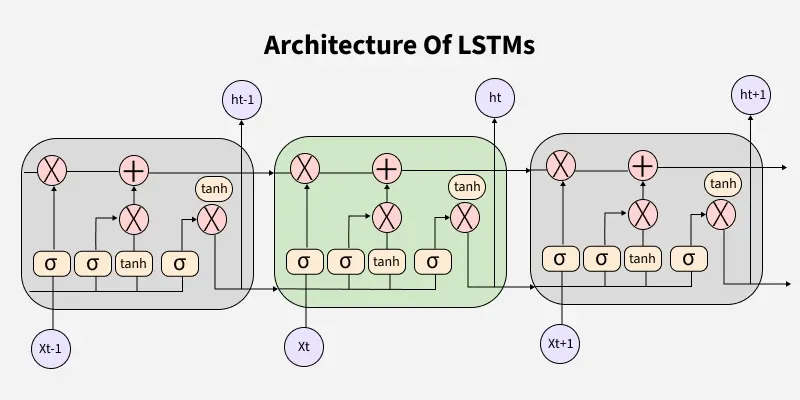

## 1. Import Libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from keras import layers
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences

## 2️. Load IMDb Dataset
We’ll use a pre-tokenized dataset of 50,000 movie reviews — half for training, half for testing.

Each review is represented as a sequence of integers corresponding to words.

Example:
https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

In [ ]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=10000)
print('Training samples:', len(x_train))
print('Testing samples:', len(x_test))
print('Example review:', x_train[0][:10])
print('Label:', y_train[0])

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Training samples: 25000
Testing samples: 25000
Example review: [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]
Label: 1


##What’s happening:

We load the IMDb movie review dataset, which is built into Keras.
It has 50,000 reviews, each labeled:

* 1 → positive sentiment

* 0 → negative sentiment

num_words=10000 means we only keep the 10,000 most frequent words (to simplify vocabulary).

Data is automatically split into training (25k) and testing (25k) sets.

**Note:** So far, the text has been converted into numbers that represent words.

## 3. Decode Numeric Reviews to Text
Let’s convert the numeric reviews back into readable sentences for better understanding.

###How IMDb Data Is Stored
* Each review is represented as a sequence of integers
* Each number corresponds to a word from the dataset’s vocabulary.
* These numbers are not directly readable, so Keras provides:
* This gives you a dictionary mapping words → integers, e.g.:
**{'the': 1, 'and': 2, 'a': 3, 'to': 4, 'of': 5, ...}**
* We create a dictionary that maps integers back to words


In [ ]:
word_index = imdb.get_word_index()
reverse_word_index = {v: k for k, v in word_index.items()}

def decode_review(text_ids):
    return ' '.join([reverse_word_index.get(i - 3, '?') for i in text_ids])

print(decode_review(x_train[0])[:500])

? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to ever


### **Why i - 3?**
In the IMDb dataset, the numbers 0, 1, and 2 are reserved for special tokens:

**0	<<PAD>PAD>** — padding token

**1	<<START>START>** — start of a review

**2	<<UNK>UNK>** — unknown word (not in vocabulary)

So, the actual words in word_index start from index 3.

**'?'** is Placeholder for unknown words

## 4. Preprocess Data
All reviews must have the **same length** before feeding into an LSTM. We’ll use `pad_sequences()` to pad or truncate each review to 200 words.

In [ ]:
max_len = 200
x_train = pad_sequences(x_train, maxlen=max_len)
x_test = pad_sequences(x_test, maxlen=max_len)
print('Shape after padding:', x_train.shape, x_test.shape)

Shape after padding: (25000, 200) (25000, 200)


## 5. Build LSTM Model
The model includes:
- **Embedding layer** – converts word IDs into dense vectors.
  * Input: sequences of word indices (e.g., [12, 45, 78, ...])
  * Output: word vectors (32-dimensional in this case)
  * Learns meaningful vector representations for words during training.
  * The word “great” and “amazing” will get similar vectors.
- **LSTM layer** – captures context in word sequences.
  * A type of Recurrent Neural Network (RNN) designed to remember long-term dependencies.  
  * This layer helps the model “understand” sentence structure and context.
  * It processes sequences word by word, keeping track of context.  
  * 64 → number of LSTM units (memory cells).
  * dropout and recurrent_dropout help prevent overfitting  
- **Dense layer** – outputs sentiment (positive/negative).
  * A fully connected layer with one output neuron.
  * activation='sigmoid' gives output between 0 and 1 — representing probability of “positive review”.

* Loss function: binary_crossentropy (since it’s a binary classification problem)
* Optimizer: adam — adaptive gradient descent method.
* Metric: accuracy.
* This defines how the model learns and how we measure its success.

In [ ]:
model = keras.Sequential([
    layers.Embedding(10000, 64, input_length=max_len),
    layers.LSTM(64),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.build(input_shape=(None, max_len))

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 200, 64)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 673,089 (2.57 MB)

 Trainable params: 673,089 (2.57 MB)

 Non-trainable params: 0 (0.00 B)

## 6. Train the Model
* The model trains on 80% of the training data (validation_split=0.2 keeps 20% for validation).
* **Epoch** = one full pass through the training dataset.
* **Batch size** = number of samples processed before weights are updated.

During training, Keras will show:
* loss and accuracy on training data.
* val_loss and val_accuracy on validation data.

The model gradually adjusts its weights to minimize loss and increase accuracy.

In [ ]:
history = model.fit(
    x_train, y_train,
    epochs=3,
    batch_size=128,
    validation_split=0.2
)

Epoch 1/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 59s 361ms/step - accuracy: 0.6508 - loss: 0.6011 - val_accuracy: 0.8502 - val_loss: 0.3470
Epoch 2/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 56s 355ms/step - accuracy: 0.8910 - loss: 0.2714 - val_accuracy: 0.8452 - val_loss: 0.3571
Epoch 3/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 56s 358ms/step - accuracy: 0.9279 - loss: 0.1970 - val_accuracy: 0.8692 - val_loss: 0.3109


## 7. Evaluate Model

In [ ]:
loss, acc = model.evaluate(x_test, y_test)
print(f'Test Accuracy: {acc:.4f}')

782/782 ━━━━━━━━━━━━━━━━━━━━ 25s 32ms/step - accuracy: 0.8616 - loss: 0.3286
Test Accuracy: 0.8630


##Plot accuracy and loss curves:
* history contains the training metrics over epochs.
* We can see how the model improved during training.


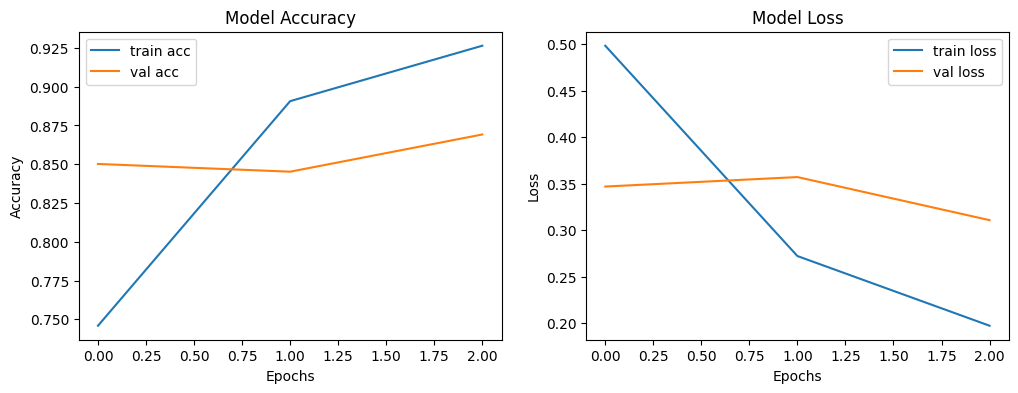

In [ ]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## 8. Test on New Review
* The model outputs a probability between 0 and 1.
* **0.5** → positive sentiment
* **≤ 0.5** → negative sentiment

In [ ]:
sample_review = x_test[0]
print('Decoded Review:\n', decode_review(x_test[1]))
prediction = model.predict(np.array([sample_review]))
print('\nPredicted sentiment:', 'Positive' if prediction[0][0] > 0.5 else 'Negative')

Decoded Review:
 psychological ? it's very interesting that robert altman directed this considering the style and structure of his other films still the trademark altman audio style is evident here and there i think what really makes this film work is the brilliant performance by sandy dennis it's definitely one of her darker characters but she plays it so perfectly and convincingly that it's scary michael burns does a good job as the mute young man regular altman player michael murphy has a small part the ? moody set fits the content of the story very well in short this movie is a powerful study of loneliness sexual ? and desperation be patient ? up the atmosphere and pay attention to the wonderfully written script br br i praise robert altman this is one of his many films that deals with unconventional fascinating subject matter this film is disturbing but it's sincere and it's sure to ? a strong emotional response from the viewer if you want to see an unusual film some might even sa

## Summary
- Loaded IMDb data
- Decoded numeric reviews
- Preprocessed and padded sequences
- Built an LSTM for sentiment classification
- Evaluated and tested model predictions